# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [171]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

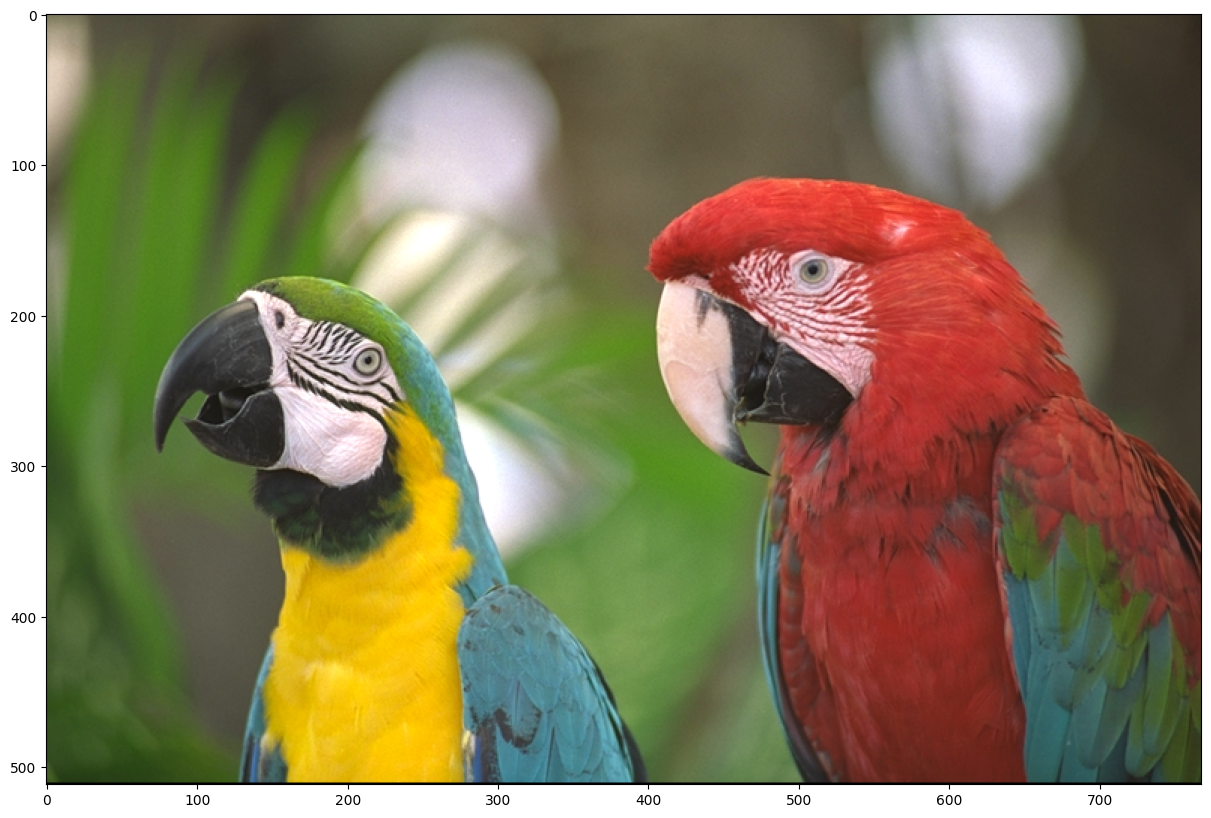

In [172]:
# Load image
img = cv2.imread('kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [270]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors_cluster = kmeans.cluster_centers_


# Black, dark gray, light gray, white
colors_black = np.array([[0, 0, 0],
                   [32, 32, 32],
                   [192, 192, 192],
                   [255, 255, 255]])

colors_bw = np.array([[0, 0, 0],
                   [255, 255, 255]])

colors_rgb = np.array([[255, 0, 0],
                   [0, 255, 0],
                   [0, 0, 255]]);


colors_colorful = np.array([[0, 0, 0],
					[127, 127, 127],
					[136, 0, 21],
					[237, 28, 36],
					[255, 127, 39],
					[255, 242, 0],
					[34, 177, 76],
					[203, 228, 253],
					[0, 162, 232], 
					[63, 72, 204],
					[255, 255, 255],
					[195, 195, 195], 
					[185, 122, 87], 
					[255, 174, 201], 
					[255, 201, 14], 
					[239, 228, 176], 
					[181, 230, 29], 
					[153, 217, 234], 
					[112, 146, 190], 
					[200, 191, 231]])

colors_colorful2 = 	[(0, 0, 0),
					(127, 127, 127),
					(136, 0, 21),
					(237, 28, 36),
					(255, 127, 39),
					(255, 242, 0),
					(34, 177, 76),
					(203, 228, 253),
					(0, 162, 232), 
					(63, 72, 204),
					(255, 255, 255),
					(195, 195, 195), 
					(185, 122, 87), 
					(255, 174, 201), 
					(255, 201, 14), 
					(239, 228, 176), 
					(181, 230, 29), 
					(153, 217, 234), 
					(112, 146, 190), 
					(200, 191, 231)]



Using the colour pallette, let's quantize the original image.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x285f8278520>)

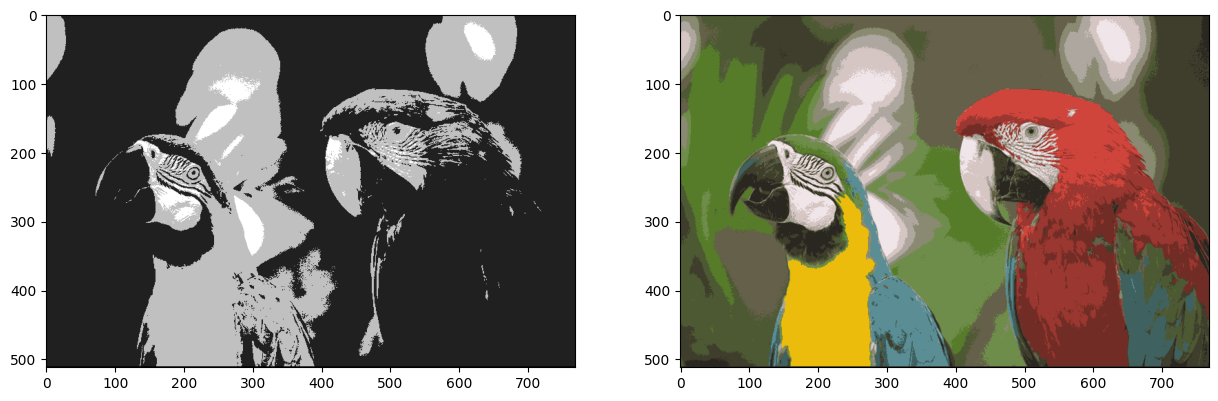

In [205]:
import math
# Cast the image to float
img = img.astype(float)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)
quantized_color = np.zeros_like(img)


def closest(color, colors):
    #colors = np.array(colors)
    color = np.array(color)
    distances = np.sqrt(np.sum((colors-color)**2,axis=1))
    index_of_smallest = np.where(distances==np.amin(distances))
    smallest_distance = colors[index_of_smallest]
    return smallest_distance[0] 

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r,c]
        #print(img[1,1]);
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here

        # Apply quantization
        quantized[r, c] = closest(pixel, colors_black);
        quantized_color[r, c] = closest(pixel, colors_cluster);
# Show quantized image (don't forget to cast back to uint8)
#quantized = quantized.astype(np.uint8)
quantized = np.maximum(quantized, np.zeros(quantized.shape))
quantized = np.minimum(quantized, 255 * np.ones(quantized.shape))
quantized = quantized.round().astype(np.uint8)

quantized_color = np.maximum(quantized_color, np.zeros(quantized_color.shape))
quantized_color = np.minimum(quantized_color, 255 * np.ones(quantized_color.shape))
quantized_color = quantized_color.round().astype(np.uint8)

plt.subplot(121), plt.imshow(quantized)
plt.subplot(122), plt.imshow(quantized_color)


In [271]:
# Compute average quantization error
def mse(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return mse

print('MSE', mse(img, quantized))
print('MSE', mse(img, quantized_color))
#avg_quant_error = 

MSE 3688.4912
MSE 140.50055


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x285968e34c0>)

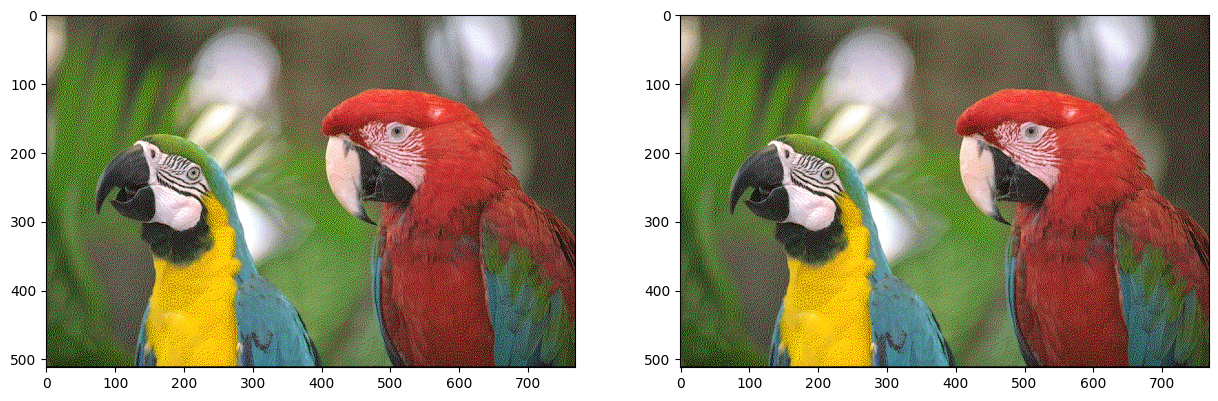

In [272]:
# Make a temporal copy of the original image, we will need it for error diffusion

img_tmp = np.copy(img)
dithering = np.copy(img)

img_tmp = img_tmp.astype(float)
dithering = dithering.astype(float)

rows, cols, channels = img_tmp.shape;

for r in range(0,rows):
    for c in range(0,cols):
        # Extract the original pixel value
        old_pixel = img_tmp[r,c]
        #print('r',r,'c',c,'oldp',old_pixel)
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        new_pixel = closest(old_pixel, colors_colorful);  
        #print('r',r,'c',c,'oldp',old_pixel)
        
        old_pixelR = old_pixel[0]
        old_pixelG = old_pixel[1]        
        old_pixelB = old_pixel[2]

        new_pixelR = new_pixel[0]
        new_pixelG = new_pixel[1]        
        new_pixelB = new_pixel[2]

        img_tmp[r,c] = new_pixel;
        #print(new_pixel)
        #dithering[r, c] = closest(old_pixel, colors_colorful);     
        # Compute quantization error    
        # 
        #print('r',r,'c',c,'oldp', old_pixelR, old_pixelG, old_pixelB)

        quant_errorR = old_pixelR - new_pixelR;
        quant_errorG = old_pixelG - new_pixelG;
        quant_errorB = old_pixelB - new_pixelB;

        #quant_error = [quant_errorR, quant_errorG,quant_errorB]

        quant_error = np.array([quant_errorR,
                   quant_errorG,
                   quant_errorB]);       
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        if (c + 1) < cols:
            img_tmp[r,c+1] += quant_error * 0.4375 # right, 7 / 16
        if ((r + 1) < rows) and ((c + 1) < cols):         
            img_tmp[r+1,c+1] += quant_error * 0.0625 # right, down, 1 / 16
        if (r + 1) < rows:  
            img_tmp[r+1,c] += quant_error * 0.3125 # down, 5 / 16            
        if (c - 1 >= 0) and (r + 1 < rows):
            img_tmp[r+1,c-1] += quant_error * 0.1875 # left, down, 3 / 16

        
        # Apply dithering
        #dithering[r, c] = img_tmp[r,c];
        dithering[r, c, :] = new_pixel;
        
#print(img_tmp);
img_tmp = np.maximum(img_tmp, np.zeros(img_tmp.shape))
img_tmp = np.minimum(img_tmp, 255 * np.ones(img_tmp.shape))
img_tmp = img_tmp.round().astype(np.uint8)

img = img.round().astype(np.uint8)


dithering = np.maximum(dithering, np.zeros(dithering.shape))
dithering = np.minimum(dithering, 255 * np.ones(dithering.shape))
dithering = dithering.round().astype(np.uint8)

#print(img_tmp);
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_tmp)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [269]:
# Compute average quantization error for dithered image
avg_optimally_quantized_error = print('MSE', mse(img, img_tmp))
avg_dith_error = print('MSE', mse(img, dithering))

#print(dithering);

MSE 14766.355
MSE 14766.355


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
* Which image looks better to you?
* Can you repeat the same process using only two colours: black and white? Show me :-)

Answers:

There is no much difference between optimally quantized and dithered; visually both pictures look the same for me. I have a feeling that I made a mistake in the code and don't fully understand the difference between ptimally quantized and dithered. If you have a free minute, I would like to discuss this with you. Thank you in advance!

Blak and white process below:

colors_bw = np.array([[0, 0, 0], [255, 255, 255]])
Code:

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x285955e3370>)

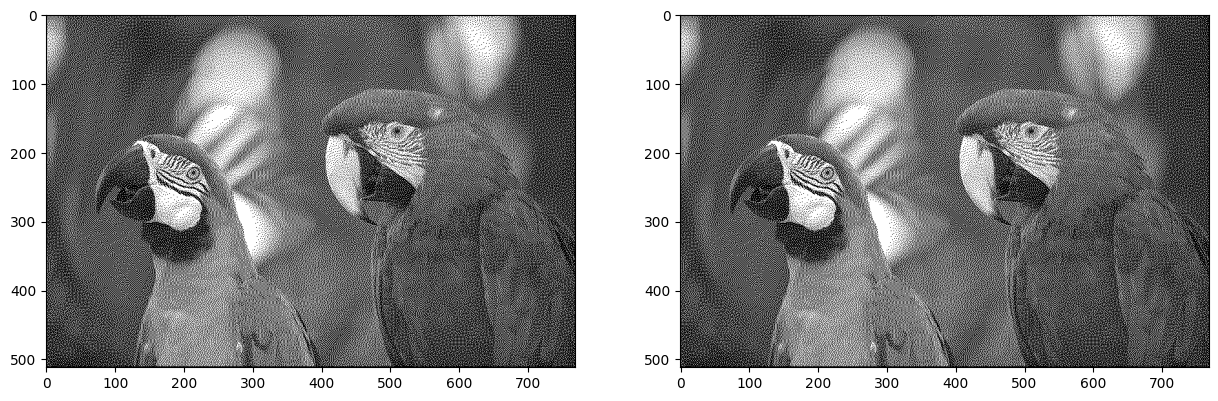

In [273]:
# Make a temporal copy of the original image, we will need it for error diffusion

img_tmp = np.copy(img)
dithering = np.copy(img)

img_tmp = img_tmp.astype(float)
dithering = dithering.astype(float)

rows, cols, channels = img_tmp.shape;

for r in range(0,rows):
    for c in range(0,cols):

        old_pixel = img_tmp[r,c]
        new_pixel = closest(old_pixel, colors_bw);  #COLOR PALETTE GOES HERE
        
        old_pixelR = old_pixel[0]; old_pixelG = old_pixel[1]; old_pixelB = old_pixel[2]
        new_pixelR = new_pixel[0]; new_pixelG = new_pixel[1]; new_pixelB = new_pixel[2]

        img_tmp[r,c] = new_pixel;

        quant_errorR = old_pixelR - new_pixelR;
        quant_errorG = old_pixelG - new_pixelG;
        quant_errorB = old_pixelB - new_pixelB;

        quant_error = np.array([quant_errorR, quant_errorG, quant_errorB]);       
        # Diffuse the quantization error accroding to the FS diffusion matrix

        if (c + 1) < cols:
            img_tmp[r,c+1] += quant_error * 0.4375 # right, 7 / 16
        if ((r + 1) < rows) and ((c + 1) < cols):         
            img_tmp[r+1,c+1] += quant_error * 0.0625 # right, down, 1 / 16
        if (r + 1) < rows:  
            img_tmp[r+1,c] += quant_error * 0.3125 # down, 5 / 16            
        if (c - 1 >= 0) and (r + 1 < rows):
            img_tmp[r+1,c-1] += quant_error * 0.1875 # left, down, 3 / 16
       
        # Apply dithering
        dithering[r, c, :] = new_pixel;
        
img_tmp = img_tmp.round().astype(np.uint8)
img = img.round().astype(np.uint8)


dithering = np.maximum(dithering, np.zeros(dithering.shape))
dithering = np.minimum(dithering, 255 * np.ones(dithering.shape))
dithering = dithering.round().astype(np.uint8)

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img_tmp)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [276]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 3)))
colors_cluster16 = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=32).fit(np.reshape(img, (-1, 3)))
colors_cluster32 = kmeans.cluster_centers_

kmeans = KMeans(n_clusters=256).fit(np.reshape(img, (-1, 3)))
colors_cluster256 = kmeans.cluster_centers_


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x285977e4790>)

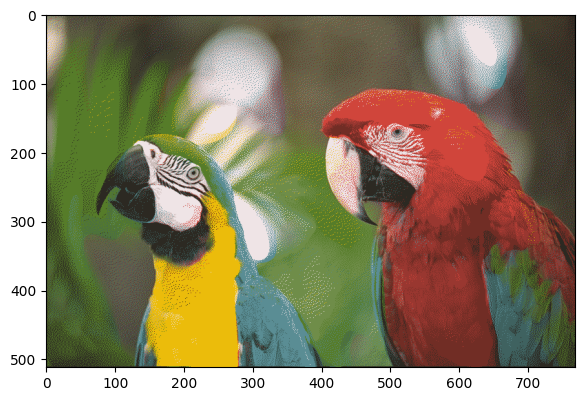

In [292]:

img_tmp = np.copy(img)
dithering = np.copy(img)

img_tmp = img_tmp.astype(float)
dithering = dithering.astype(float)

rows, cols, channels = img_tmp.shape;

for r in range(0,rows):
    for c in range(0,cols):

        old_pixel = img_tmp[r,c]
        new_pixel = closest(old_pixel, colors_cluster16);  #COLOR PALETTE GOES HERE
        
        old_pixelR = old_pixel[0]; old_pixelG = old_pixel[1]; old_pixelB = old_pixel[2]
        new_pixelR = new_pixel[0]; new_pixelG = new_pixel[1]; new_pixelB = new_pixel[2]

        img_tmp[r,c] = new_pixel;

        quant_errorR = old_pixelR - new_pixelR;
        quant_errorG = old_pixelG - new_pixelG;
        quant_errorB = old_pixelB - new_pixelB;

        quant_error = np.array([quant_errorR, quant_errorG, quant_errorB]);       
        # Diffuse the quantization error accroding to the FS diffusion matrix

        if (c + 1) < cols:
            img_tmp[r,c+1] += quant_error * 0.4375 # right, 7 / 16
        if ((r + 1) < rows) and ((c + 1) < cols):         
            img_tmp[r+1,c+1] += quant_error * 0.0625 # right, down, 1 / 16
        if (r + 1) < rows:  
            img_tmp[r+1,c] += quant_error * 0.3125 # down, 5 / 16            
        if (c - 1 >= 0) and (r + 1 < rows):
            img_tmp[r+1,c-1] += quant_error * 0.1875 # left, down, 3 / 16
       
        # Apply dithering
        dithering[r, c, :] = new_pixel;
        
img_tmp = img_tmp.round().astype(np.uint8)
img = img.round().astype(np.uint8)


dithering = np.maximum(dithering, np.zeros(dithering.shape))
dithering = np.minimum(dithering, 255 * np.ones(dithering.shape))
dithering = dithering.round().astype(np.uint8)

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(122), plt.imshow(dithering)   # dithering

Apply FS dithering the same way you did before.
* How does the result look like to you?
* What happens if we use 32 colours?
* And what happens if we use 256 colours?

Answer: With 256 colors it will more look like original natural image (MSE 61.225323), 32 colors is better than 16. But even with the onebit image it is still great visual result.

32 colors:

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x28581290340>)

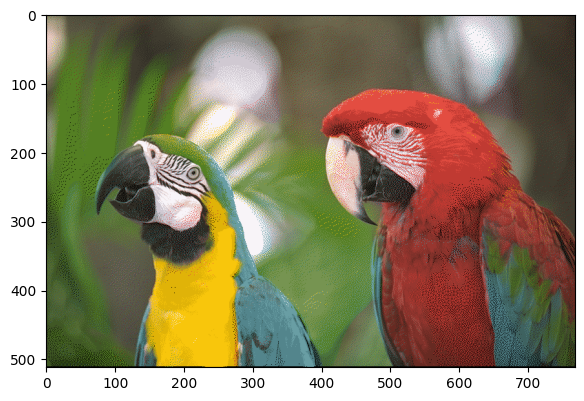

In [293]:
img_tmp = np.copy(img)
dithering = np.copy(img)

img_tmp = img_tmp.astype(float)
dithering = dithering.astype(float)

rows, cols, channels = img_tmp.shape;

for r in range(0,rows):
    for c in range(0,cols):

        old_pixel = img_tmp[r,c]
        new_pixel = closest(old_pixel, colors_cluster32);  #COLOR PALETTE GOES HERE
        
        old_pixelR = old_pixel[0]; old_pixelG = old_pixel[1]; old_pixelB = old_pixel[2]
        new_pixelR = new_pixel[0]; new_pixelG = new_pixel[1]; new_pixelB = new_pixel[2]

        img_tmp[r,c] = new_pixel;

        quant_errorR = old_pixelR - new_pixelR;
        quant_errorG = old_pixelG - new_pixelG;
        quant_errorB = old_pixelB - new_pixelB;

        quant_error = np.array([quant_errorR, quant_errorG, quant_errorB]);       
        # Diffuse the quantization error accroding to the FS diffusion matrix

        if (c + 1) < cols:
            img_tmp[r,c+1] += quant_error * 0.4375 # right, 7 / 16
        if ((r + 1) < rows) and ((c + 1) < cols):         
            img_tmp[r+1,c+1] += quant_error * 0.0625 # right, down, 1 / 16
        if (r + 1) < rows:  
            img_tmp[r+1,c] += quant_error * 0.3125 # down, 5 / 16            
        if (c - 1 >= 0) and (r + 1 < rows):
            img_tmp[r+1,c-1] += quant_error * 0.1875 # left, down, 3 / 16
       
        # Apply dithering
        dithering[r, c, :] = new_pixel;
        
img_tmp = img_tmp.round().astype(np.uint8)
img = img.round().astype(np.uint8)


dithering = np.maximum(dithering, np.zeros(dithering.shape))
dithering = np.minimum(dithering, 255 * np.ones(dithering.shape))
dithering = dithering.round().astype(np.uint8)

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img)   # dithering
plt.subplot(122), plt.imshow(dithering)   # dithering

256 Colors:

MSE 61.225323


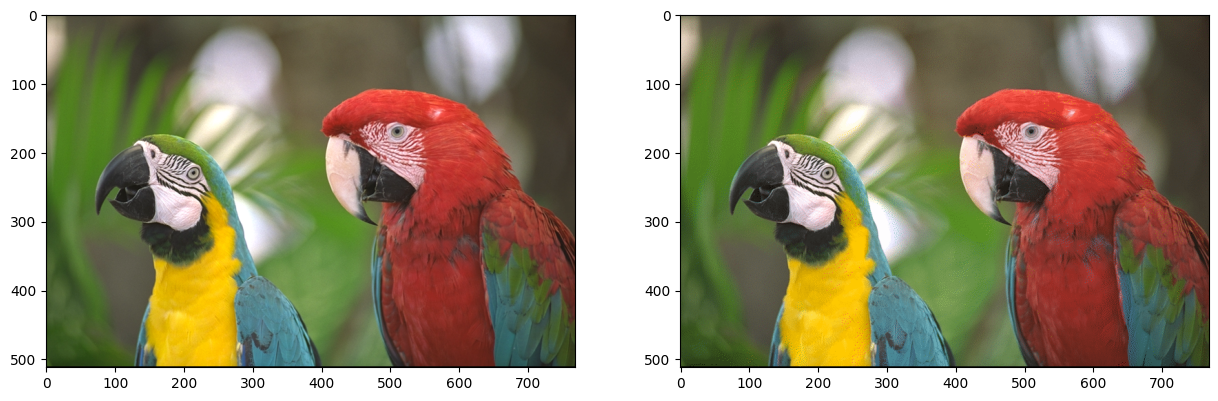

In [296]:
img_tmp = np.copy(img)
dithering = np.copy(img)

img_tmp = img_tmp.astype(float)
dithering = dithering.astype(float)

rows, cols, channels = img_tmp.shape;

for r in range(0,rows):
    for c in range(0,cols):

        old_pixel = img_tmp[r,c]
        new_pixel = closest(old_pixel, colors_cluster256);  #COLOR PALETTE GOES HERE
        
        old_pixelR = old_pixel[0]; old_pixelG = old_pixel[1]; old_pixelB = old_pixel[2]
        new_pixelR = new_pixel[0]; new_pixelG = new_pixel[1]; new_pixelB = new_pixel[2]

        img_tmp[r,c] = new_pixel;

        quant_errorR = old_pixelR - new_pixelR;
        quant_errorG = old_pixelG - new_pixelG;
        quant_errorB = old_pixelB - new_pixelB;

        quant_error = np.array([quant_errorR, quant_errorG, quant_errorB]);       
        # Diffuse the quantization error accroding to the FS diffusion matrix

        if (c + 1) < cols:
            img_tmp[r,c+1] += quant_error * 0.4375 # right, 7 / 16
        if ((r + 1) < rows) and ((c + 1) < cols):         
            img_tmp[r+1,c+1] += quant_error * 0.0625 # right, down, 1 / 16
        if (r + 1) < rows:  
            img_tmp[r+1,c] += quant_error * 0.3125 # down, 5 / 16            
        if (c - 1 >= 0) and (r + 1 < rows):
            img_tmp[r+1,c-1] += quant_error * 0.1875 # left, down, 3 / 16
       
        # Apply dithering
        dithering[r, c, :] = new_pixel;
        
img_tmp = img_tmp.round().astype(np.uint8)
img = img.round().astype(np.uint8)


dithering = np.maximum(dithering, np.zeros(dithering.shape))
dithering = np.minimum(dithering, 255 * np.ones(dithering.shape))
dithering = dithering.round().astype(np.uint8)

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(img)   # dithering
plt.subplot(122), plt.imshow(dithering)   # dithering
avg_dith_error = print('MSE', mse(img, dithering))